In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn import svm

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.under_sampling import RandomUnderSampler


In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
column_names_file = "../Dataset/kddcup.names"
columns = []
first = True
with open(column_names_file, 'r') as f:
    for line in f:
        if first:
            first = False
            continue
        line = line.strip()
        columns.append(line.split()[0][:-1])

print(columns)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [4]:
file_path = "../Dataset/kddcup.data.corrected"
df = pd.read_csv(file_path, names=columns)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,tcp,http,SF,215,45076,0,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,162,4528,0,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,236,1228,0,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,233,2032,0,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
# Remove trailing periods from the last column values
df.rename(columns={df.columns[-1]: 'label'}, inplace=True)
df['label'] = df['label'].str.rstrip('.')  # clean trailing period if any

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,label
0,tcp,http,SF,215,45076,0,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal
0,tcp,http,SF,162,4528,0,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal
0,tcp,http,SF,236,1228,0,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal
0,tcp,http,SF,233,2032,0,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal
0,tcp,http,SF,239,486,0,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal


In [6]:
df.label.value_counts()

label
smurf              2807886
neptune            1072017
normal              972781
satan                15892
ipsweep              12481
portsweep            10413
nmap                  2316
back                  2203
warezclient           1020
teardrop               979
pod                    264
guess_passwd            53
buffer_overflow         30
land                    21
warezmaster             20
imap                    12
rootkit                 10
loadmodule               9
ftp_write                8
multihop                 7
phf                      4
perl                     3
spy                      2
Name: count, dtype: int64

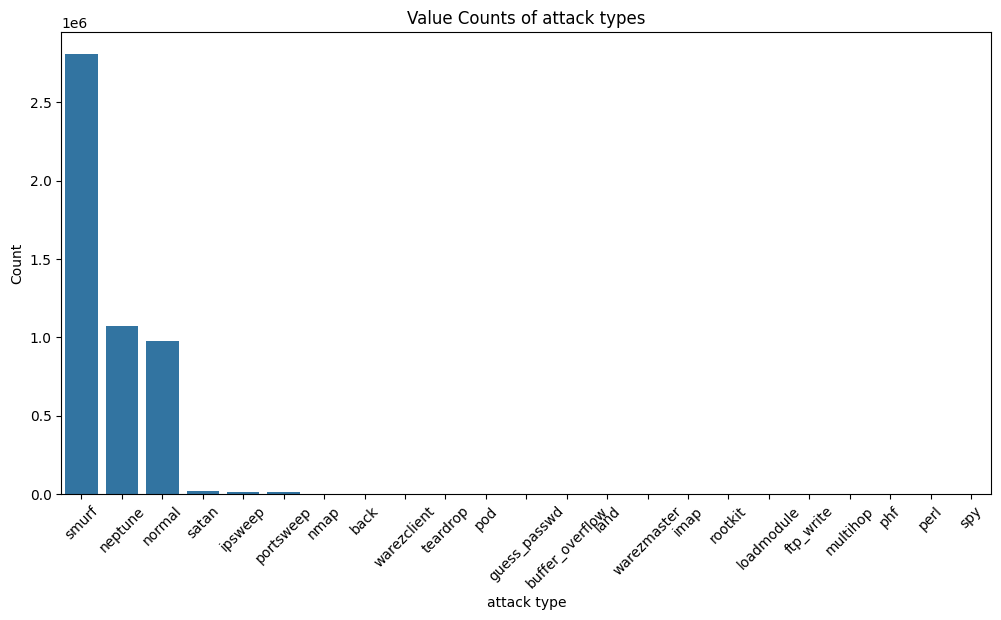

In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Value Counts of attack types')
plt.xlabel('attack type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()  

In [8]:
# 1 for dos attacks, 0 for others
dos_attacks = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']
df['attack_type'] = df.label.apply(lambda x: 1 if x in dos_attacks else 0)

In [9]:
df.attack_type.value_counts()

attack_type
1    3883370
0    1015061
Name: count, dtype: int64

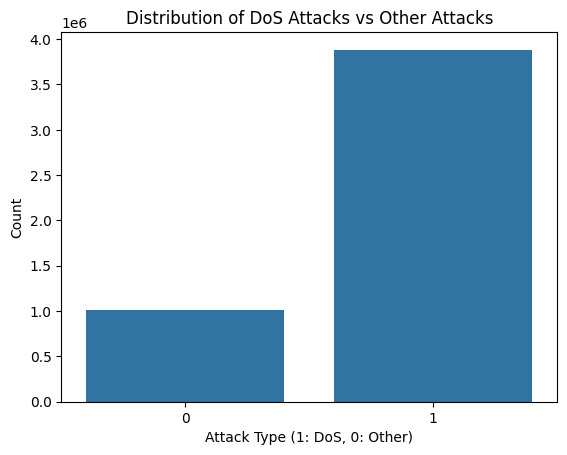

In [10]:
sns.countplot(x='attack_type', data=df)
plt.title('Distribution of DoS Attacks vs Other Attacks')
plt.xlabel('Attack Type (1: DoS, 0: Other)')
plt.ylabel('Count')
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4898431 entries, 0 to 0
Data columns (total 42 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   duration                     object 
 1   protocol_type                object 
 2   service                      object 
 3   flag                         int64  
 4   src_bytes                    int64  
 5   dst_bytes                    int64  
 6   land                         int64  
 7   wrong_fragment               int64  
 8   urgent                       int64  
 9   hot                          int64  
 10  num_failed_logins            int64  
 11  logged_in                    int64  
 12  num_compromised              int64  
 13  root_shell                   int64  
 14  su_attempted                 int64  
 15  num_root                     int64  
 16  num_file_creations           int64  
 17  num_shells                   int64  
 18  num_access_files             int64  
 19  num_outboun

In [12]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [13]:
X = df.drop(columns=['label', 'attack_type'])
y = df['attack_type']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [14]:
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_raw, y_train, train_size=0.1, stratify=y_train, random_state=RANDOM_STATE
)

In [15]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = rus.fit_resample(X_train_sample, y_train_sample)

In [16]:
print(f"Original training set shape: {X_train_raw.shape}")
print(f"Sampled training set shape: {X_train_sample.shape}")
print(f"Balanced training set shape: {X_train_bal.shape}")
print(f"Class distribution after balancing: {np.bincount(y_train_bal)}")

Original training set shape: (3918744, 40)
Sampled training set shape: (391874, 40)
Balanced training set shape: (162410, 40)
Class distribution after balancing: [81205 81205]


In [17]:
categoric = X_train_bal.select_dtypes(include='object').columns.tolist()
numeric = X_train_bal.select_dtypes(exclude='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoric)
    ]
)

In [22]:
def train_SVM(X_train_bal, y_train_bal, X_test_raw, y_test, kernel):
    
    use_proba = kernel != "sigmoid"
    
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', svm.SVC(kernel=kernel, probability=use_proba, random_state=RANDOM_STATE))
    ])

    print(f"\nTraining SVM with kernel={kernel}\n")
    
    clf.fit(X_train_bal, y_train_bal)
    print("Train (balanced set) Acc:", clf.score(X_train_bal, y_train_bal))
    print("Test (original dist) Acc:", clf.score(X_test_raw, y_test))

    # Predict class labels directly
    y_pred = clf.predict(X_test_raw)
    print(classification_report(y_test, y_pred, digits=4))
    print(confusion_matrix(y_test, y_pred))

    if use_proba:
        y_prob = clf.predict_proba(X_test_raw)[:, 1]
        ap = average_precision_score(y_test, y_prob)
        print("Average Precision (PR AUC):", ap)

        prec, rec, thr = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(rec, prec, label=f'{kernel.upper()} Kernel (AP={ap:.3f})')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve - {kernel.upper()} Kernel")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Skipping probability-based metrics and plots for sigmoid kernel.")

    return clf

In [21]:
train_SVM(X_train_bal, y_train_bal, X_test_raw, y_test, "sigmoid")


Training SVM with kernel=sigmoid

Train (balanced set) Acc: 0.9293270118835047
Test (original dist) Acc: 0.9303644939659299
              precision    recall  f1-score   support

           0     0.7778    0.9296    0.8469    203012
           1     0.9806    0.9306    0.9549    776675

    accuracy                         0.9304    979687
   macro avg     0.8792    0.9301    0.9009    979687
weighted avg     0.9386    0.9304    0.9325    979687

[[188711  14301]
 [ 53920 722755]]
Skipping probability-based metrics and plots for sigmoid kernel.


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



Training SVM with kernel=linear

Train (balanced set) Acc: 0.9998706976171418
Test (original dist) Acc: 0.9997713555451895
              precision    recall  f1-score   support

           0     0.9991    0.9997    0.9994    203012
           1     0.9999    0.9998    0.9999    776675

    accuracy                         0.9998    979687
   macro avg     0.9995    0.9998    0.9997    979687
weighted avg     0.9998    0.9998    0.9998    979687

[[202961     51]
 [   173 776502]]
Average Precision (PR AUC): 0.9999076751515464


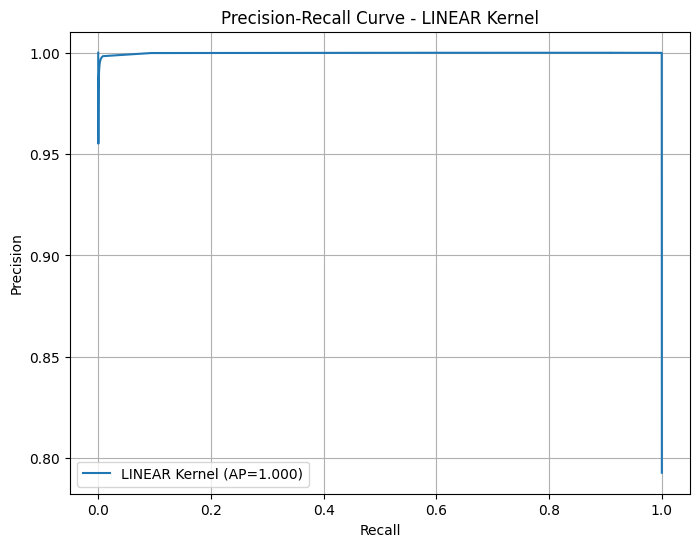


Training SVM with kernel=poly

Train (balanced set) Acc: 0.9997044516963242
Test (original dist) Acc: 0.9994967780525821
              precision    recall  f1-score   support

           0     0.9977    0.9999    0.9988    203012
           1     1.0000    0.9994    0.9997    776675

    accuracy                         0.9995    979687
   macro avg     0.9988    0.9996    0.9992    979687
weighted avg     0.9995    0.9995    0.9995    979687

[[202989     23]
 [   470 776205]]
Average Precision (PR AUC): 0.9999456743712395


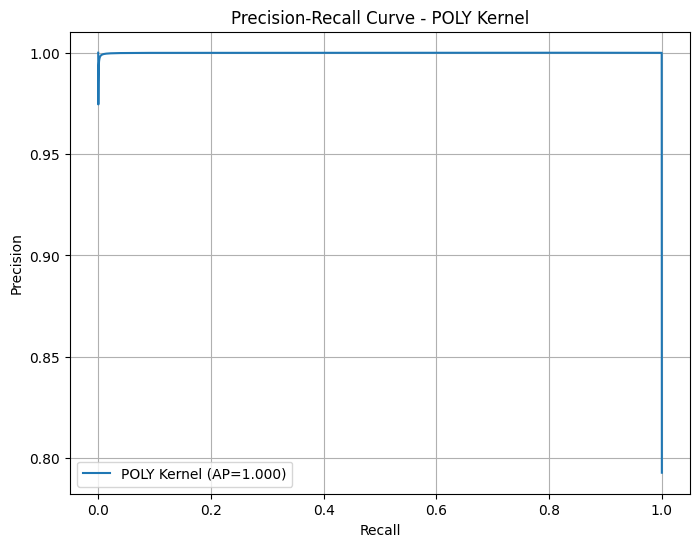


Training SVM with kernel=rbf

Train (balanced set) Acc: 0.9999630564620405
Test (original dist) Acc: 0.9999203827344856
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998    203012
           1     1.0000    0.9999    0.9999    776675

    accuracy                         0.9999    979687
   macro avg     0.9998    0.9999    0.9999    979687
weighted avg     0.9999    0.9999    0.9999    979687

[[202991     21]
 [    57 776618]]
Average Precision (PR AUC): 0.999999992349759


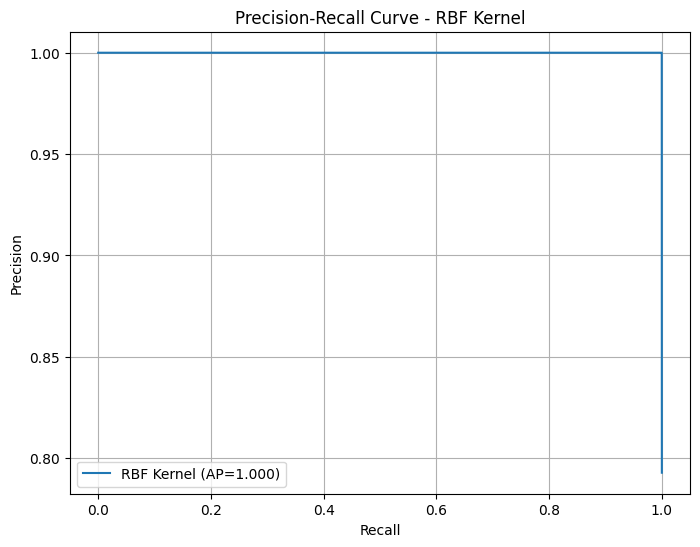


Training SVM with kernel=sigmoid

Train (balanced set) Acc: 0.9293270118835047
Test (original dist) Acc: 0.9303644939659299
              precision    recall  f1-score   support

           0     0.7778    0.9296    0.8469    203012
           1     0.9806    0.9306    0.9549    776675

    accuracy                         0.9304    979687
   macro avg     0.8792    0.9301    0.9009    979687
weighted avg     0.9386    0.9304    0.9325    979687

[[188711  14301]
 [ 53920 722755]]
Skipping probability-based metrics and plots for sigmoid kernel.


In [23]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
models = {}

for kernel in kernels:
    models[kernel] = train_SVM(X_train_bal, y_train_bal, X_test_raw, y_test, kernel)
    

In [25]:
linear_clf = models['linear']
ohe = linear_clf.named_steps['preprocessor'].named_transformers_['cat']
feature_names = numeric + list(ohe.get_feature_names_out(categoric))

coef = linear_clf.named_steps['classifier'].coef_[0]
top_features = sorted(zip(feature_names, coef), key=lambda x: abs(x[1]), reverse=True)[:10]

print("Top 10 informative features:")
for f, w in top_features:
    print(f"{f}: {w:.4f}")

Top 10 informative features:
protocol_type_ecr_i: 2.6998
is_host_login: -2.3236
count: 2.0796
duration_icmp: 1.9435
dst_host_srv_diff_host_rate: 1.7261
service_S0: 1.6368
serror_rate: 1.5611
duration_udp: -1.5556
rerror_rate: 1.3602
urgent: 1.3482
